# Callbacks

often you may want to do something with your model at some point during training, for example save the model, stop training, change the learning rate, etc. if you were writing your own training loop, you could add the functions you want to call at each step, but since you are using a fit function provided by Tensorflow you can't do that. in return Tensorflow provides away to achieve this goal with callbacks.

Callbacks are objects extending the `tf.keras.callbacks.Callback` class. They are passed to the `fit` function (or any function that operates the model e.g. `evaluate` or `predict`), they include a set of methods to be called when certain events occur during training.

## Events of interest

For each event you want to execute the call back must implement a method with the same name as the event, for example `on_epoch_end` for the `epoch_end` event.

### Global methods

1. `on_(train|test|predict)_begin(self, logs=None)`: Called at the beginning of fit/evaluate/predict.
2. `on_(train|test|predict)_end(self, logs=None)`: Called at the end of fit/evaluate/predict.

### Batch-level methods for training/testing/predicting

1. `on_(train|test|predict)_batch_begin(self, batch, logs=None)`: Called right before processing a batch during training/testing/predicting.
2. `on_(train|test|predict)_batch_end(self, batch, logs=None)`: Called at the end of training/testing/predicting a batch. Within this method, logs is a dict containing the metrics results.

### Epoch-level methods (training only) **Most used**

1. `on_epoch_begin(self, epoch, logs=None)`: Called at the beginning of an epoch during training.
2. `on_epoch_end(self, epoch, logs=None)`: Called at the end of an epoch during training.


# Built-in callbacks

Tensorflow provides a set of built-in callbacks that you can use to control the training process, for example:

1. `tf.keras.callbacks.EarlyStopping`: Stops training when a monitored quantity has stopped improving.
2. `tf.keras.callbacks.ModelCheckpoint`: Saves the model after every epoch.
3. `tf.keras.callbacks.TensorBoard`: Writes summary data to Tensorboard.
4. `tf.keras.callbacks.ReduceLROnPlateau`: Reduces the learning rate when a metric has stopped improving.

And more, you can find a complete list of callbacks in the [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback).


### Using a callback

You tell tensorflow to call the callbacks you want from the `callbacks` parameter in functions like `fit`, `evaluate` or `predict`.

```python
my_callback = customCallBack()
stopEarly = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.fit( ..., callbacks=[my_callback, stopEarly]) # you pass the object not the class
```


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%load_ext autoreload
%autoreload 2

# Early stopping and Model ModelCheckpoint callbacks

Early stopping is a callback that stops training when a monitored quantity has stopped improving, and ModelCheckpoint is a callback that saves the model after every epoch.


# Tensorboard callback

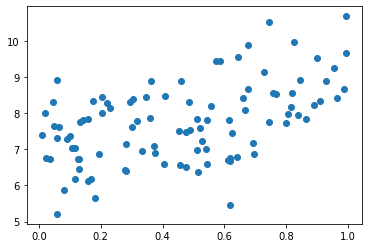

In [3]:
from simple_model import get_simple_regression_data

(X_train, y_train), (X_test, y_test) = get_simple_regression_data()

plt.scatter(X_train, y_train)
plt.show()

# Custom callbacks

At somepoint you may want to carry out operations that no builtin callback would do for you, like certain plots, or event some logs, for that you can extend the `tf.keras.callbacks.Callback` class yourself to implement your own callbacks.

```python
class MyCustomCallback(tf.keras.callbacks.Callback):
  # define the events of interest here
  def on_epoch_end(self, epoch, logs=None):
    # do something at the end of each epoch
```

Of course you might wonder, how on earth can you for example test the model with a callback, save the weights, keep track of the loss, etc. if you have no access to them, as you see the event function always takes epoch or batch number, and some logs.

**Logs**: it's a dictionary with the metrics results after the last batch or epoch, and it's useful for keeping track of the mertics.

to access the model itself you can use the `model` attribute like `self.model` inside the callback, this enables you to stop the training, save the weights, change the learning rate, or even use the model right away to see how well it's doing.


# Custom callback: TestingPlotCallback

it's allows me to display the testing results during training after each `epoch_step` epochs, it extends `PlottingCallback` which initializes the figure and subplots, then the `on_epoch_end` method is called after each epoch to fill the subplots.

It was mainly used for demo purposes, but would need some update to work more generally.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from math import floor

class PlottingCallback:
  def __init__(self, epochs_step, steps, title):
    super(PlottingCallback, self).__init__()
    self.epochs_step = epochs_step
    self.steps = steps

    # we will draw a number of subplots depending on the `steps` parameter
    # so we use it to compute the rows and columns for the subplots grid
    rows = (steps + 4) // 5
    cols = 5

    self.fig, self.plots = plt.subplots(rows, cols, figsize=(17, rows * 3))
    self.fig.suptitle(title, fontsize=15, color='forestgreen')

    # make sure to leave some padding between the subplots
    self.fig.tight_layout(pad=3.0)

    self.plots = self.plots.flatten() # to allow looping over them in single for loop

class TestingPlotCallback(PlottingCallback, tf.keras.callbacks.Callback):
  def __init__(self, steps = 5, epochs_step=10, test_data=None):
    super(TestingPlotCallback, self).__init__(epochs_step, steps, "Testing")
    
    self.test_data = test_data

    # compute the limits for x and y axes for the subplot grid
    y_min, y_max = min(test_data[1])[0], max(test_data[1])[0]
    yspread = y_max - y_min
    x_min, x_max = min(test_data[0])[0], max(test_data[0])[0]
    xspread = x_max - x_min
    

    self.lims = {
      "x": (
        floor(x_min - xspread * 0.1), 
        floor(x_max + xspread * 0.1), 
        floor(xspread * 1.2 // 5)
      ),
      "y": (
        floor(y_min - 0.1 * yspread),
        floor(y_max + 0.1 * yspread),
        floor(yspread * 1.2 // 5)
      )
    }

  def on_epoch_end(self, epoch, logs={}):
    mark = self.epochs_step - 1
    if epoch > 0 and (epoch + 1) % self.epochs_step == 0:
      step = epoch // mark - 1
      test_x, test_y = self.test_data
      ax = self.plots[step]
    
      # plot the expected and predicted values
      ax.scatter(test_x, test_y, label='test', color='red')
      ax.plot(test_x, self.model.predict(test_x), label='prediction', color='blue')
      ax.legend(['Test', 'Pred'])
      ax.set_title(f'Epoch: {epoch + 1}')

      y_min, y_max, y_step = self.lims["y"]
      ax.set_xticks(np.arange(*(self.lims['x'])))
      ax.set_yticks(np.arange(y_min, y_max, y_step))
      self.fig.add_subplot(ax)